# Overview

This notebook is part of the project for the [Big Data Computing AY2020/21 course](https://github.com/gtolomei/big-data-computing) teached by Prof. Gabriele Tolomei

Other resources:
- a [demo notebook](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/3816168353014773/3017902888537112/3248872990014382/latest.html) without the training parts and with the evaluation, search engine and adversarial attack phases
- a [brief presentation](https://drive.google.com/file/d/1U7q5Gj-56AYK8tfbTeIhcAZjBH98TB51/view?usp=sharing) of this project
- a [GitHub repo](https://github.com/rom42pla/big_data_project) with all the material


The project has been done by:
- Romeo Lanzino, matricola `1753403`, email `lanzino.1753403@studenti.uniroma1.it`
- Federico Fontana, matricola `1744946`, email `fontana.1744946@studenti.uniroma1.it`

<img src="https://www.chimicifisici.it/wp-content/uploads/2019/04/Sapienza_logo-1024x307.png" alt="drawing" width="400"/>

## Task
We have decided to tackle **semi-supervised multi-class images classification**, consisting of a dataset with both labeled and (a large amount of) unlabeled samples [_\[Van Engelen, Hoos, 2019, A survey on semi-supervised learning\]_](https://link.springer.com/content/pdf/10.1007/s10994-019-05855-6.pdf)

## Dataset
We've chosen [STL-10](https://cs.stanford.edu/~acoates/stl10/) [_\[Coates, Lee, Ng, 2011, An Analysis of Single Layer Networks in Unsupervised Feature Learning\]_](https://cs.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf), which is an image recognition dataset with a corpus of 100K unlabeled images, 5K labeled training images and 8K labeled test images, covering 10 different classes. 

Unlike [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) [_\[Krizhevsky, 2009, Learning Multiple Layers of Features from Tiny Images\]_](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf) (from which takes inspiration), the dataset has a higher resolution which makes it a challenging benchmark for developing more scalable unsupervised learning methods; the compressed
dataset weights 2.5GB, which seems a reasonable choice due to storage’s limitations of Databricks Community Edition

## Workflow

- download, analyze and **preprocess the dataset**
- contrast the curse of dimensionality using **dimensionality reduction** techniques such as a CNN
- **train a model** (such as a MLP) on the labeled training images
- **pseudo-label** the unlabeled images using the model trained in the previous step
- **train a second model** using also the pseudo-labeled images
- **evaluate** the results of both models to see if there have been some improvements
- implement an **image search engine** that, given a query image as input, returns a list of relevant images in a gallery (disjointed from the query images set) 
- perform an example of **adversarial attack**

Each step will be covered in details in its respective section of this notebook

# Environment setup

## Global variables

This section contains references to variables used in this notebook, such as the learning rate of a model or the numbers of results the search engine will return for each query image

The following variables apply to PySpark's configuration

In [0]:
# how many rows per batch e.g. in @pandas_udf functions  
SPARK_MAX_RECORDS_PER_BATCH = 1e3
# how many bytes can a single partition store
SPARK_MAX_PARTITION_BYTES = 1e8

The following variables apply to the feature engineering part

In [0]:
# wheter to use a sample of df_unlabeled to reduce memory usage
USE_REDUCED_DF_UNLABELED = True

The following variables apply to `base_model`, the MLP that will train on `df_train` only

In [0]:
# how many iterations should the MLP do during the training
BASE_MODEL_ITERATIONS = 50
# how many neurons in MLP's hidden layer
BASE_MODEL_HIDDEN_LAYER_SIZE = 512
# learning rate of the MLP
BASE_MODEL_LEARNING_RATE = 1e-3

The following variables apply to `final_model`, the MLP that will train on `df_pseudolabel` (`df_unlabeled` classified with `base_model`)

In [0]:
# number of k-folds during cross-validation
FINAL_MODEL_K_FOLDS = 3
# how many iterations should the MLP do during the training
FINAL_MODEL_ITERATIONS = 50
# how many neurons in MLP's hidden layer
FINAL_MODEL_HIDDEN_LAYER_SIZE = 512
# learning rate of the MLP
FINAL_MODEL_LEARNING_RATE = 1e-3

The following variables apply to the search engine part

In [0]:
# how many experiments with the search engine
# e.g. if SEARCH_ENGINE_QUERIES == 2, then a random image is selected as a query and their results are shown
# after that, a second random image is selected and their results are shown
SEARCH_ENGINE_QUERIES = 2
SEARCH_ENGINE_TOP_K_RESULTS = 8

## Setup

In [0]:
!pip install --upgrade pip 

import time

Requirement already satisfied: pip in /databricks/python3/lib/python3.8/site-packages (21.1.2)

In [0]:
def print_available_ram(): # in MB
  !free --mega
  pass

In [0]:
spark.conf.set("spark.sql.execution.arrow.enabled", True)
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", int(SPARK_MAX_RECORDS_PER_BATCH))
spark.conf.set("spark.sql.files.maxPartitionBytes", int(SPARK_MAX_PARTITION_BYTES))

spark.catalog.clearCache()

In [0]:
starting_time = time.time()
print_available_ram()

total used free shared buff/cache available
Mem: 10595 9933 415 2 246 662
Swap: 10485 742 9742

# Data retrieval

In [0]:
import os
from os import makedirs
from os.path import join, exists
from pprint import pprint

!pip install gdown
import gdown

Requirement already satisfied: gdown in /databricks/python3/lib/python3.8/site-packages (3.13.0)
Requirement already satisfied: tqdm in /databricks/python3/lib/python3.8/site-packages (from gdown) (4.61.1)
Requirement already satisfied: filelock in /usr/local/lib/python3.8/site-packages (from gdown) (3.0.12)
Requirement already satisfied: six in /usr/local/lib/python3.8/site-packages (from gdown) (1.15.0)
Requirement already satisfied: requests[socks]>=2.12.0 in /databricks/python3/lib/python3.8/site-packages (from gdown) (2.24.0)
Requirement already satisfied: idna<3,>=2.5 in /databricks/python3/lib/python3.8/site-packages (from requests[socks]>=2.12.0->gdown) (2.10)
Requirement already satisfied: urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1 in /databricks/python3/lib/python3.8/site-packages (from requests[socks]>=2.12.0->gdown) (1.25.11)
Requirement already satisfied: chardet<4,>=3.0.2 in /databricks/python3/lib/python3.8/site-packages (from requests[socks]>=2.12.0->gdown) (3.0.4)
Requirement already satisfied: certifi>=2017.4.17 in /databricks/python3/lib/python3.8/site-packages (from requests[socks]>=2.12.0->gdown) (2020.12.5)
Requirement already satisfied: PySocks!=1.5.7,>=1.5.6 in /databricks/python3/lib/python3.8/site-packages (from requests[socks]>=2.12.0->gdown) (1.7.1)

## Download

The [STL-10 dataset](https://ai.stanford.edu/~acoates/stl10/) is available as `.bin` files containing Numpy arrays representing images and labels

Although this can be handy in other contexts, PySpark cannot natively load such files into a dataframe; common practice is to use known file types (such as `.csv`) that PySpark can easily read and parallelize with functions such as `spark.read`, so we needed to locally convert the `.bin` dataset to a more usable format

We've decided to use [`.parquet`](https://databricks.com/glossary/what-is-parquet), an open source file format designed for efficient as well as performant flat columnar storage format of data compared to row based files like `.csv` or `.tsv` files

The local preprocessing step roughly translates to:
- download the dataset in `.bin` format
- save each image-array as `.png`
- build three dataframes using PySpark or Pandas, since `.parquet` can be read from both frameworks: one for the labeled training images, another for the labeled test images and a last for the unlabeled images, each with a row for each image, a column containing the flattened arrays of the images and (for the labeled datasets only, of course) a column containing the labels of the images
- exports the three dataframes as `.parquet` files; note that a large dataframe can be exported as more than one `.parquet` file
- load the `.parquet` files somewhere on the web

After that, we're here able to directly download the `.parquet` files from a [shared Google Drive folder](https://drive.google.com/drive/folders/1te7m9u-FkjxYeopz1AG6N4wP-GoMDyBi?usp=sharing)

In [0]:
def download_stl10_parquet(path: str = ".") -> str:  
  stl10_parts_ids = [("stl10_train.parquet", "1OUDFIXnfhGRgxVS6NHmZfuXAkEEGEKHK"), 
                     ("stl10_test.parquet", "1UHN32csZqJEA3S94HS5PKpz3Y_OuJC2b"),
                     ("stl10_unlabeled_part1.parquet", "1VMFDf3haZRkCp_St6oP2pniAlq-c8lzS"), 
                     ("stl10_unlabeled_part2.parquet", "1mBuH0GrW_vB42i4WZovg_a8mTJlUvF0m"), 
                     ("stl10_unlabeled_part3.parquet", "1fM6ZBKWY34JS54XCRGwsedA_73VR0Wjo"), 
                     ("stl10_unlabeled_part4.parquet", "1aZkzLgk4UfvMl7nA6lOvF_fpRmXgUJ_J"), 
                     ("stl10_unlabeled_part5.parquet", "108YmXt-1pODfgTMl5LUFeSl8NIWroARU"), 
                     ("stl10_unlabeled_part6.parquet", "1XzPvGHbf33sm-EmE-1pcbWV1b1hmOvN4"), 
                     ("stl10_unlabeled_part7.parquet", "1-cKfFt-wRVLRq5Btekt9uGse4Cha-ZH1"), 
                     ("stl10_unlabeled_part8.parquet", "1VsIbWYSdZjnGm7hJw2dPVdkA8bTKuCK0")]
  stl10_path = join(path, "stl10_parquet")
  # creates the folders if needed
  if not exists(stl10_path):
    makedirs(stl10_path)
  if stl10_path not in [f.path.replace("dbfs:", "") for f in dbutils.fs.ls(f"{path}")]:
    dbutils.fs.mkdirs(stl10_path)
  # loops over each file id
  for stl10_part_filename, stl10_part_id in stl10_parts_ids:
    if stl10_part_filename not in [f.name.replace("dbfs:", "") for f in dbutils.fs.ls(stl10_path)]:
      # downloads the file
      print(f"Downloading 'https://drive.google.com/uc?id={stl10_part_id}' to '{join(stl10_path, stl10_part_filename)}'...")
      gdown.download(f"https://drive.google.com/uc?id={stl10_part_id}", join(stl10_path, stl10_part_filename), quiet=True)
      # sends the file to dbfs
      print(f"Copying '{join(stl10_path, stl10_part_filename)}' to 'dbfs:{join(stl10_path, stl10_part_filename)}'...")
      dbutils.fs.cp(f"file:{join(stl10_path, stl10_part_filename)}", f"dbfs:{join(stl10_path, stl10_part_filename)}")
  print(f"Everything synced")
  pprint([f.path for f in dbutils.fs.ls(f'{stl10_path}')])
  return stl10_path

In [0]:
# downloads the .parquet dataset into "dbfs:/tmp/stl10_parquet" folder 
stl10_path = download_stl10_parquet("/tmp")

Everything synced
['dbfs:/tmp/stl10_parquet/stl10_test.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_train.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part1.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part2.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part3.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part4.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part5.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part6.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part7.parquet',
 'dbfs:/tmp/stl10_parquet/stl10_unlabeled_part8.parquet']

## Loading into PySpark

Datasets are then directly read from `dbfs` using Spark's `spark.read.parquet` built-in function

As the unlabeled part of the dataset is split into several smaller `.parquet` files, they are sequentially read and merged together into a single dataframe

In [0]:
from pyspark.sql.types import StringType, ArrayType, FloatType, ByteType
from pyspark.sql.functions import monotonically_increasing_id

In [0]:
# prepares the paths
df_test_path = "dbfs:/tmp/stl10_parquet/stl10_test.parquet"
df_train_path = "dbfs:/tmp/stl10_parquet/stl10_train.parquet"
df_unlabeled_paths = [path.path for path in dbutils.fs.ls(stl10_path) if "unlabeled" in path.name]

# reads the dataframes
df_train = spark.read.parquet(df_train_path)
df_test = spark.read.parquet(df_test_path)
if USE_REDUCED_DF_UNLABELED:
  df_unlabeled = spark.read.parquet(df_unlabeled_paths[0]) 
else:
  df_unlabeled = spark.read.parquet(*[path.path for path in dbutils.fs.ls(stl10_path) if "unlabeled" in path.name]) 

Since the datasets are huge with respect to our cluster, we compress each number in the flattened arrays of `image` column from `IntegerType` (4 bytes, in \\([-2147483648, 2147483647]\\)) to `ByteType` (1 byte, in \\([-128, 127]\\))

Numbers in the original files are in \\([0, 255]\\), so we don't have a loss of informations after such transformation

Here you can find [more infos on PySpark's data types](https://spark.apache.org/docs/latest/sql-ref-datatypes.html)

In [0]:
# "compresses" the images column 
image_as_byte = udf(lambda values: [int(value) for value in values], ArrayType(ByteType()))
df_train = df_train.withColumn("image", image_as_byte(df_train["image"]))
df_test = df_test.withColumn("image", image_as_byte(df_test["image"]))
df_unlabeled = df_unlabeled.withColumn("image", image_as_byte(df_unlabeled["image"]))

To uniquely identify each image in a dataframe, we'll add an `id` column containing a unique randomly generated integer for each row using a [PySpark's native transformation](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.monotonically_increasing_id.html)

In [0]:
# adds an id column
df_train = df_train.withColumn("id", monotonically_increasing_id())
df_test = df_test.withColumn("id", monotonically_increasing_id())
df_unlabeled = df_unlabeled.withColumn("id", monotonically_increasing_id())

Since we do have to access these dataframes until the end of the notebook, it makes sense to cache them to have them always ready

In [0]:
df_train.cache()
df_test.cache()
df_unlabeled.cache()

Out[17]: DataFrame[image: array<tinyint>, id: bigint]

# Features engineering

## Preliminary data analysis

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install Pillow
!pip install torch==1.8.1+cpu torchvision==0.9.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
import torch
from torch import nn
import torchvision
from torchvision import transforms as T

from pyspark.sql.dataframe import DataFrame
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, udf, count
from pyspark.ml.linalg import Vectors, VectorUDT

Requirement already satisfied: Pillow in /databricks/python3/lib/python3.8/site-packages (8.2.0)
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already satisfied: torch==1.8.1+cpu in /databricks/python3/lib/python3.8/site-packages (1.8.1+cpu)
Requirement already satisfied: torchvision==0.9.1+cpu in /databricks/python3/lib/python3.8/site-packages (0.9.1+cpu)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from torch==1.8.1+cpu) (1.19.2)
Requirement already satisfied: typing-extensions in /databricks/python3/lib/python3.8/site-packages (from torch==1.8.1+cpu) (3.10.0.0)
Requirement already satisfied: pillow>=4.1.1 in /databricks/python3/lib/python3.8/site-packages (from torchvision==0.9.1+cpu) (8.2.0)

In [0]:
def plot_random_image(df: DataFrame, title: str = None) -> np.ndarray:
  # retrieves a random row and its image
  row = df.sample(0.001).first()
  image = np.asarray(row["image"])
  # eventually unflattens the image
  if len(image.shape) == 1:
    side = int(np.sqrt(image.shape[0]/3))
    image = np.reshape(image, (side, side, 3))
  # plots the image
  image[image < 0] += 256
  plt.imshow(image)
  plt.title(title)
  plt.show()
  return image
  

def plot_labels_distribution(df, title: str = None):
  # retrieves labels' distribution
  labels_distribution = [(row.label, row["count(label)"])
                         for row in df.select("label").groupby("label").agg(count("label")).collect()]
  # plots the distribution
  sns.barplot(x=[row[0] for row in labels_distribution], 
              y=[row[1] for row in labels_distribution], 
              palette="rocket").set_title(title)
  plt.show()

The dataset is composed by three dataframes:

- `df_train`, which contains 5,000 labeled training images
- `df_test`, which contains 8,000 labeled test images
- `df_unlabeled`, which contains 100,000 unlabeled images

In [0]:
print(f"|df_unlabeled| = {df_unlabeled.count()} (in {df_unlabeled.rdd.getNumPartitions()} partitions)")
df_unlabeled.show(n=4)

print(f"|df_train| = {df_train.count()} (in {df_train.rdd.getNumPartitions()} partitions)")
df_train.show(n=4)

print(f"|df_test| = {df_test.count()} (in {df_test.rdd.getNumPartitions()} partitions)")
df_test.show(n=4)

|df_unlabeled| = 12500 (in 4 partitions)
+--------------------+----------+
 image| id|
+--------------------+----------+
[126, -128, -127,...|8589934592|
[119, 115, 123, -...|8589934593|
[4, 13, 5, 59, 74...|8589934594|
[-98, -101, -105,...|8589934595|
+--------------------+----------+
only showing top 4 rows

df_train| = 5000 (in 2 partitions)
+--------------------+--------+---+
 image| label| id|
+--------------------+--------+---+
[0, 2, 4, 0, 2, 4...|airplane| 0|
[83, 115, 110, 83...|airplane| 1|
[109, 112, 117, 1...|airplane| 2|
[-58, -58, -48, -...|airplane| 3|
+--------------------+--------+---+
only showing top 4 rows

df_test| = 8000 (in 3 partitions)
+--------------------+--------+----------+
 image| label| id|
+--------------------+--------+----------+
[47, 91, -104, 47...|airplane|8589934592|
[-92, -95, -102, ...|airplane|8589934593|
[-67, -64, -71, -...|airplane|8589934594|
[51, -109, -7, 52...|airplane|8589934595|
+--------------------+--------+----------+
only showing top 4 rows

Images are 96x96 with 3 color channels (RGB) and saved as flattened arrays of 96\*96\*3 = 27,648 elements

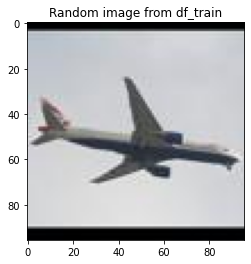

Images have shape (96, 96, 3)

In [0]:
random_image = plot_random_image(df=df_train, title=f"Random image from df_train")
print(f"Images have shape {random_image.shape}")

`df_train` and `df_test` both have a balanced labels' distribution (same amount of samples per class)

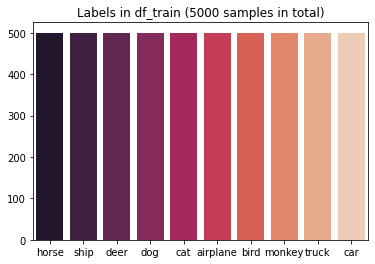

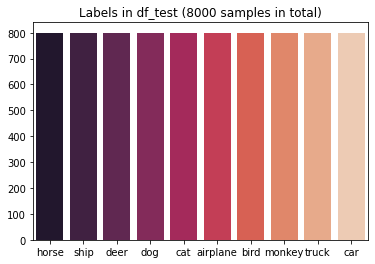

In [0]:
plot_labels_distribution(df_train, 
                         title=f"Labels in df_train ({df_train.count()} samples in total)")
plot_labels_distribution(df_test, 
                         title=f"Labels in df_test ({df_test.count()} samples in total)")

## Dimensionality reduction

In order to reduce the dimensionality of image (represented by \\(96 \times 96 \times 3\\) integers) and contrast the **curse of dimensionality** phenomena, one can exploit different **dimensionality reduction techniques**:

- **PCA**: reduce the dimensionality of a dataset while preserving as much 'variability' (i.e. statistical information) as possible. The standard context for PCA as an exploratory data analysis tool involves a dataset with observations on \\( p \\) numerical variables, for each of \\( n \\) entities or individuals. These data values define  an \\( n \times p \\) data matrix \\( X \\), whose \\( j \\)th column is the vector \\( x_t \\) of observations on the \\( j \\)th variable. From that, we seek a linear combination of the columns of matrix \\(X\\) with maximum variance [\[Jolliffe, Cadima, 2016\]](https://royalsocietypublishing.org/doi/10.1098/rsta.2015.0202)
- **CNN**: it is common practice to use as-is or fine-tune pretrained convolutional neural networks as backbones for images' dimensionality reduction: is it possible to feed an image to this backbone and take image's representation (embeddings) just before the last classification layer to have a meaningful, reduced represention of the input

For computational purposes we'll choose a CNN model with a low number of parameters to speed-up the computation: [SqueezeNet 1.0](https://pytorch.org/hub/pytorch_vision_squeezenet/)

In [0]:
# loops over different PyTorch's models
for model_name, model in [("ResNet18", torchvision.models.resnet18), 
                          ("MobileNet v3-small", torchvision.models.mobilenet_v3_small),
                          ("SqueezeNet 1.0", torchvision.models.squeezenet1_0)]:
  # retrieves the number of parameters of the model
  parameters = sum(p.numel() for p in model(pretrained=False).parameters())
  print(f"{model_name} has {parameters} parameters")

ResNet18 has 11689512 parameters
MobileNet v3-small has 2542856 parameters
SqueezeNet 1.0 has 1248424 parameters

This cell downloads and instantiate a pretrained version of the CNN

Since SqueezeNet requires normalized images' colors, each image fed to it needs to be preprocessed [(more about it)](https://pytorch.org/vision/stable/models.html)

In [0]:
# retrieves the backbone model
squezze =torchvision.models.squeezenet1_0(pretrained=True) 
mobilev3small=torchvision.models.mobilenet_v3_small(pretrained=True) 

  
model = nn.Sequential(
      mobilev3small.features, 
      mobilev3small.avgpool, 
      torch.nn.Flatten(1),
      mobilev3small.classifier[0]
  #squezze.features,
  #squezze.classifier
)

# freezes model's parameters
model.eval()
for p in model.parameters():
  p.requires_grad = False
  
# transformations to do on each image before processing it
image_preprocessing = T.Compose([
  T.Normalize(mean=[0.485, 0.456, 0.406], 
              std=[0.229, 0.224, 0.225]),
  T.Resize((224,224))
])

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth
 0%| | 0.00/4.79M [00:00<?, ?B/s] 35%|███▌ | 1.68M/4.79M [00:00<00:00, 17.3MB/s] 95%|█████████▌| 4.55M/4.79M [00:00<00:00, 24.6MB/s]100%|██████████| 4.79M/4.79M [00:00<00:00, 24.1MB/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

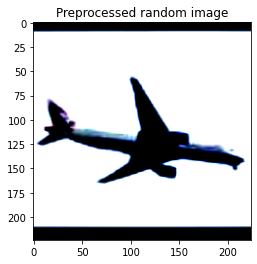

In [0]:
random_image_preprocessed = torch.from_numpy(random_image)/255
random_image_preprocessed = random_image_preprocessed.permute(2, 0, 1)
random_image_preprocessed = image_preprocessing(random_image_preprocessed)
random_image_preprocessed = random_image_preprocessed.permute(1, 2, 0).numpy()

plt.imshow(random_image_preprocessed)
plt.title(f"Preprocessed random image")
plt.show()

The following function parallelizes embeddings' generation using a [`@pandas_udf`](https://docs.databricks.com/spark/latest/spark-sql/udf-python-pandas.html) function

The code is inspired by [a DataBricks team's tutorial notebook](https://docs.databricks.com/_static/notebooks/deep-learning/pytorch-images.html)

In [0]:
@pandas_udf(ArrayType(FloatType()))
def predict_emb(image_batch_iter: pd.Series) -> pd.Series:
  images = np.vstack([i for i in image_batch_iter])
  images[images < 0] += 256
  images = images / 255
  images = torch.from_numpy(images).type(torch.float32)
  images = torch.reshape(images, (-1, 96, 96, 3))
  images = images.permute(0, 3, 1, 2)
  images = image_preprocessing(images)
  with torch.no_grad():
    preds = model(images)
  preds = torch.reshape(preds, (-1, 1024)).tolist()
  return pd.Series(preds)

Here a new column called `embeddings` is generated, containing the embeddings of the images

In [0]:
df_unlabeled = df_unlabeled.withColumn("embeddings", predict_emb(df_unlabeled["image"]))
df_train = df_train.withColumn("embeddings", predict_emb(df_train["image"]))
df_test = df_test.withColumn("embeddings", predict_emb(df_test["image"]))

Since PySpark's models expects `VectorUDT` to represent arrays in dataframes, the `embeddings` column is converted from arrays of floats to `VectorUDT`

In [0]:
# converts embeddings to VectorUDT
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
df_train = df_train.withColumn("embeddings", list_to_vector_udf(df_train["embeddings"]))
df_test = df_test.withColumn("embeddings", list_to_vector_udf(df_test["embeddings"]))
df_unlabeled = df_unlabeled.withColumn("embeddings", list_to_vector_udf(df_unlabeled["embeddings"]))

To better organize the memory, we'll create different datasets for the embeddings, the ones whose name ends with `_emb`

For example:
- `df_train` will contain the `image` column but not the `embeddings` one
- `df_train_emb` will contain the `embeddings` column but not the `image` one

In [0]:
# saves just the embedding dataframes
df_train_emb = df_train.drop("image")
df_test_emb = df_test.drop("image")
df_unlabeled_emb = df_unlabeled.drop("image")

# caches the embeddings dataframes for faster use
df_train_emb.cache()
df_test_emb.cache()
df_unlabeled_emb.cache()

# we're done with df_train
df_train.unpersist()

Out[29]: DataFrame[image: array<tinyint>, label: string, id: bigint, embeddings: vector]

In [0]:
embeddings_size = len(df_train_emb.first()["embeddings"])
print(f"Embeddings size is {embeddings_size}")

print(f"|df_unlabeled_emb| = {df_unlabeled_emb.count()} (in {df_unlabeled_emb.rdd.getNumPartitions()} partitions)")
df_unlabeled_emb.show(n=4)

print(f"|df_train_emb| = {df_train_emb.count()} (in {df_train_emb.rdd.getNumPartitions()} partitions)")
df_train_emb.show(n=4)

print(f"|df_test_emb| = {df_test_emb.count()} (in {df_test_emb.rdd.getNumPartitions()} partitions)")
df_test_emb.show(n=4)

Embeddings size is 1024
df_unlabeled_emb| = 12500 (in 4 partitions)
+----------+--------------------+
 id| embeddings|
+----------+--------------------+
8589934592|[-0.5278005599975...|
8589934593|[-0.1671304404735...|
8589934594|[-0.8427834510803...|
8589934595|[-0.6230177879333...|
+----------+--------------------+
only showing top 4 rows

df_train_emb| = 5000 (in 2 partitions)
+--------+---+--------------------+
 label| id| embeddings|
+--------+---+--------------------+
airplane| 0|[-0.5840396285057...|
airplane| 1|[-0.3303175568580...|
airplane| 2|[-1.2865829467773...|
airplane| 3|[-0.0749394893646...|
+--------+---+--------------------+
only showing top 4 rows

df_test_emb| = 8000 (in 3 partitions)
+--------+----------+--------------------+
 label| id| embeddings|
+--------+----------+--------------------+
airplane|8589934592|[-3.0076751708984...|
airplane|8589934593|[-1.2043626308441...|
airplane|8589934594|[0.42445918917655...|
airplane|8589934595|[-0.2033578157424...|
+--------+----------+--------------------+
only showing top 4 rows

# Base model's training

In [0]:
!pip install mlflow

import json
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Requirement already satisfied: mlflow in /databricks/python3/lib/python3.8/site-packages (1.17.0)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.19.2)
Requirement already satisfied: docker>=4.0.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.0.0)
Requirement already satisfied: gitpython>=2.1.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.1.17)
Requirement already satisfied: click>=7.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (8.0.1)
Requirement already satisfied: entrypoints in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.3)
Requirement already satisfied: gunicorn in /databricks/python3/lib/python3.8/site-packages (from mlflow) (20.1.0)
Requirement already satisfied: pyyaml in /databricks/python3/lib/python3.8/site-packages (from mlflow) (5.4.1)
Requirement already satisfied: databricks-cli>=0.8.7 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.14.3)
Requirement already satisfied: prometheus-flask-exporter in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.18.2)
Requirement already satisfied: cloudpickle in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.6.0)
Requirement already satisfied: querystring-parser in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.2.4)
Requirement already satisfied: alembic<=1.4.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.4.1)
Requirement already satisfied: pandas in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.1.3)
Requirement already satisfied: sqlparse>=0.3.1 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (0.4.1)
Requirement already satisfied: requests>=2.17.3 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.24.0)
Requirement already satisfied: sqlalchemy in /databricks/python3/lib/python3.8/site-packages (from mlflow) (1.4.18)
Requirement already satisfied: Flask in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2.0.1)
Requirement already satisfied: pytz in /databricks/python3/lib/python3.8/site-packages (from mlflow) (2020.5)
Requirement already satisfied: protobuf>=3.6.0 in /databricks/python3/lib/python3.8/site-packages (from mlflow) (3.17.3)
Requirement already satisfied: python-editor>=0.3 in /databricks/python3/lib/python3.8/site-packages (from alembic<=1.4.1->mlflow) (1.0.4)
Requirement already satisfied: Mako in /databricks/python3/lib/python3.8/site-packages (from alembic<=1.4.1->mlflow) (1.1.4)
Requirement already satisfied: python-dateutil in /databricks/python3/lib/python3.8/site-packages (from alembic<=1.4.1->mlflow) (2.8.1)
Requirement already satisfied: six>=1.10.0 in /usr/local/lib/python3.8/site-packages (from databricks-cli>=0.8.7->mlflow) (1.15.0)
Requirement already satisfied: tabulate>=0.7.7 in /databricks/python3/lib/python3.8/site-packages (from databricks-cli>=0.8.7->mlflow) (0.8.9)
Requirement already satisfied: websocket-client>=0.32.0 in /databricks/python3/lib/python3.8/site-packages (from docker>=4.0.0->mlflow) (1.1.0)
Requirement already satisfied: gitdb<5,>=4.0.1 in /databricks/python3/lib/python3.8/site-packages (from gitpython>=2.1.0->mlflow) (4.0.7)
Requirement already satisfied: smmap<5,>=3.0.1 in /databricks/python3/lib/python3.8/site-packages (from gitdb<5,>=4.0.1->gitpython>=2.1.0->mlflow) (4.0.0)
Requirement already satisfied: idna<3,>=2.5 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (2.10)
Requirement already satisfied: chardet<4,>=3.0.2 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (3.0.4)
Requirement already satisfied: urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.17.3->mlflow) (1.25.11)
Requirement already satisfied: certifi>=2017.4.17 in /databricks/python3/lib/python3.8/site

## Labels' mapping

Our labels are strings (`airplane`, `bird` etc), but the MLP understands only numbers; each label needs to be mapped into an integer

In [0]:
labels = sorted([row["label"] for row in df_train_emb.select("label").distinct().collect()])

labels_map = {label: i_label for i_label, label in enumerate(labels)}
print(f"Labels with mapped integer:")
pprint(labels_map)

# saves the labels
with open("labels.json", 'w', encoding='utf-8') as fp:
  json.dump(labels_map, fp, indent=4)
dbutils.fs.mv(f"file:/databricks/driver/labels.json", f"dbfs:/labels.json", recurse=True)

# adds a column for the mapped labels
map_label = udf(lambda l: labels_map[l], IntegerType())
df_train_emb = df_train_emb.withColumn("label_mapped", map_label(df_train_emb.label)).drop("label")
df_test_emb = df_test_emb.withColumn("label_mapped", map_label(df_test_emb.label)).drop("label")

Labels with mapped integer:
{'airplane': 0,
 'bird': 1,
 'car': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'horse': 6,
 'monkey': 7,
 'ship': 8,
 'truck': 9}

## Training

PySpark offers [several types of classifiers](https://spark.apache.org/docs/latest/ml-classification-regression.html#classification), and it's crucial to empirically investigate which one works better for a given dataset

Since our data is continuous, we can already think that classifiers such as [Random Forests](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html) are probably not a good choice

After some tests we've found [Multilayer Perceptron (MLP)](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.MultilayerPerceptronClassifier.html) to work slightly better than the other classifiers

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

The training of the model will take several minutes to complete

In [0]:
# defines the model
mlp = MultilayerPerceptronClassifier(
  featuresCol="embeddings", labelCol="label_mapped", predictionCol="label_mapped_pred", 
  layers=[embeddings_size, BASE_MODEL_HIDDEN_LAYER_SIZE, BASE_MODEL_HIDDEN_LAYER_SIZE//2, len(labels_map)], 
  solver="l-bfgs", stepSize=BASE_MODEL_LEARNING_RATE, maxIter=BASE_MODEL_ITERATIONS)

# trains the model
base_model = mlp.fit(df_train_emb)

## Exporting the model

For our purposes, we'll save the model to `dbfs`

In [0]:
if f"base_model" in [file.name.replace("/", "") for file in dbutils.fs.ls("dbfs:/")]:
  print(f"Removed model previously saved")
  dbutils.fs.rm(f"dbfs:/base_model", recurse=True)
base_model.save("base_model")
print(f"Model saved in dbfs:/base_model")

Removed model previously saved
Model saved in dbfs:/base_model

# Final model's training

## Pseudo-labeling

Now that we have a working `base_model` it's time to pseudo-label the unlabeled part of the dataset to be used during the training of a new model leveraging the (previously) unlabeled data

In [0]:
from pyspark.sql.functions import col

In [0]:
df_pseudolabeled_emb = base_model.transform(df_unlabeled_emb).select("id", "embeddings", col("label_mapped_pred").alias("label_mapped"))
df_pseudolabeled_emb = df_pseudolabeled_emb.withColumn("label_mapped", df_pseudolabeled_emb["label_mapped"].cast(IntegerType()))

## Training

Since this time we have pseudo-labels (that can lead to a bias during training since some may not be correct), [\\(k\\)-fold cross validation](https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation) is used to reduce the chance to find wrongly classified, "unfortunate" splits during training and evaluation of the model [_\[Raschka, 2018, Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning\]_](https://arxiv.org/pdf/1811.12808.pdf)

In [0]:
# defines the model
mlp = MultilayerPerceptronClassifier(
  featuresCol="embeddings", labelCol="label_mapped", predictionCol="label_mapped_pred", 
  layers=[embeddings_size, FINAL_MODEL_HIDDEN_LAYER_SIZE, FINAL_MODEL_HIDDEN_LAYER_SIZE//2, len(labels_map)], 
  solver="l-bfgs", stepSize=FINAL_MODEL_LEARNING_RATE, maxIter=FINAL_MODEL_ITERATIONS)

evaluator = MulticlassClassificationEvaluator(
  predictionCol="label_mapped_pred", labelCol="label_mapped", probabilityCol="probability")

crossval = CrossValidator(estimator=mlp, evaluator=evaluator, 
                          estimatorParamMaps=ParamGridBuilder().build(),
                          numFolds=FINAL_MODEL_K_FOLDS)

# trains the model
final_model = crossval.fit(df_pseudolabeled_emb.union(df_train_emb))
df_train_emb.unpersist()

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.
Out[38]: DataFrame[id: bigint, embeddings: vector, label_mapped: int]

## Exporting the model

For our purposes, we'll save the model to `dbfs`

In [0]:
if f"final_model" in [file.name.replace("/", "") for file in dbutils.fs.ls("dbfs:/")]:
  print(f"Removed model previously saved")
  dbutils.fs.rm(f"dbfs:/final_model", recurse=True)
final_model.save("final_model")
print(f"Model saved in dbfs:/final_model")

Model saved in dbfs:/final_model

# ...check the other notebook

For the **evaluation** of the models, the **search engine** and an example of **adversarial attack**, check the [demo notebook](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/3816168353014773/3017902888537112/3248872990014382/latest.html)

In [0]:
print(f"Total execution time: {np.round((time.time() - starting_time)/60, 1)} minutes")

Total execution time: 222.1 minutes